# To do:
- add distanceM column to WWLLN
- get longer time period for WWLLN (request to Bob Holz directly?)
- spatially filter both datasets & plot to detect timing better

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
from obspy import UTCDateTime
from datetime import datetime 
#DATA_DIR = os.path.join(os.getenv('HOME'), 'DATA', 'Tonga_eruption_analysis')
DATA_DIR = os.path.join(os.getenv('HOME'), 'DATA', 'HungaTonga')

In [ ]:
from obspy.geodetics import locations2degrees, degrees2kilometers
sourcelat = -20.536
sourcelon = -175.382 

def read_wwlln():
    # Load WWLLN data
    # I got these data from Steve McNutt (email on March 1st) who got them from Bob Holzworth at UW (bobholz@uw.edu)
    # Cite: Dowden, Brundell, Rodger, Source [2002], J. Atmos. 
    # Parameters Steve asked for were -24 to -18 lat, -179 to -172 lon, 0400 to 1600 UTC
    # residual is fit residual in microseconds
    # I should add a distanceM column from -20.536, -175.382 as for the GLD360 data
    wwllnpklfile = os.path.join(DATA_DIR, 'LIGHTNING', 'WWLLN.pkl')
    if os.path.exists(wwllnpklfile):
        wwllndf = pd.read_pickle(wwllnpklfile)
    else:    
        wwllndatafile = os.path.join(DATA_DIR, 'LIGHTNING', 'A20220115.HungaTonga.loc')
        wwllndf = pd.read_csv(wwllndatafile, names=['date', 'time', 'latitude', 'longitude', 'residual', 'num_stations'])

        # Create a datetime column
        timestamp = []
        for i,row in wwllndf.iterrows():
            this_timestr = row['date'].replace('/','-')+'T'
            this_timestamp = UTCDateTime(this_timestr + row['time']).datetime
            timestamp.append(this_timestamp)
        wwllndf['datetime']=timestamp    
        wwllndf.sort_values(by='datetime',inplace=True)

        # Add other columns for plotting purposes
        wwllndf['ones']=np.ones(len(wwllndf['datetime']))
        wwllndf['cum_events']=np.cumsum(wwllndf['ones'])
        wwllndf['cum_detections']=np.cumsum(wwllndf['num_stations'])

        add_distanceM_column(wwllndf)

        # add distance weightedDetections
        weightedDetections = []
        for i, row in wwllndf.iterrows():
            try:
                weightedDetections.append(row['num_stations']/row['distanceM'])
            except:
                pass
        wwllndf['weightedDetections'] = weightedDetections       
        
        # Save to pickle files
        wwllndf.to_pickle(wwllnpklfile)        
        
    return wwllndf


def read_gld360():
    # Load Vaisala GLD360 data
    # contact is chris.vagasky@vaisala.com, see email from March 3, 2022
    # distanceM is from -20.536, -175.382. 
    gld360pklfile = os.path.join(DATA_DIR, 'LIGHTNING', 'GLD360.pkl')
    if os.path.exists(gld360pklfile):
        gld360df = pd.read_pickle(gld360pklfile)
    else:
        gld360datafile = os.path.join(DATA_DIR, 'LIGHTNING', 'Hunga_Tonga_Lightning_within_300km_December-January.csv')
        gld360df = pd.read_csv(gld360datafile)

        # Create a datetime column
        gld360df['datetime'] = [UTCDateTime(dt).datetime for dt in gld360df['time']]
        gld360df.sort_values(by='datetime',inplace=True)

        # Add other columns for plotting purposes - do not add cumulative columns unless i subset later
        gld360df['ones']=np.ones(len(gld360df['datetime']))
        gld360df['cum_events']=np.cumsum(gld360df['ones'])
        add_distanceM_column(gld360df) 
        
        # add signalPower and distance weightedPower
        signalPower = []
        weightedPower = []
        resistance = 10000 # ohms
        for i, row in gld360df.iterrows():
            try:
                thisSignalPower =  (row['signalStrengthKA']*1000)**2 * resistance
                signalPower.append(thisSignalPower)
                weightedPower.append(thisSignalPower/row['distanceM'])
            except:
                pass
        gld360df['signalPower'] = signalPower
        gld360df['weightedPower'] = weightedPower      

        # Save to pickle files
        gld360df.to_pickle(gld360pklfile)
    return gld360df

def add_distanceM_column(df):
    if not 'distanceM' in df.columns:
        df['distanceM'] = [degrees2kilometers(locations2degrees(lat, lon, sourcelat, sourcelon))*1000 for lat,lon in zip(df['latitude'],df['longitude'])]
    
# plot WWLLN data
def plot_wwlln(df, starttime='1900-01-01', endtime='2100-01-01', radiusM=12500000, \
               y_columns = ['cum_events', 'cum_detections']):    
    for ycol in y_columns:
        if not ycol in df.columns:
            y_columns.remove(ycol)
    df2 = df.loc[(df['datetime'] >= starttime)
            & (df['datetime'] < endtime) & df['distanceM'] < radiusM]       
    #fig, ax = plt.subplots(len(y_columns),1)
    linestyle='k.'
    
    fig = plt.figure(figsize=(12, 4))
    ax=[]
    #fig, ax = plt.subplots(len(y_columns),1)
    for i in range(len(y_columns)):
        ax.append(fig.add_subplot(len(y_columns), 1, i+1))
        #ax[i] = df2.plot.scatter(x='datetime', y=y_columns[i], c='DarkBlue', marker='.')
        ax[i].plot_date(df2['datetime'], df2[y_columns[i]], linestyle)
        ax[i].set_ylabel(y_columns[i])
        xtl = ax[i].get_xticklabels()
        plt.setp(xtl, rotation=45)
        if starttime:
            ax[i].set_xlim(starttime, endtime)
            
#import matplotlib.dates as mdates 
def plot_gld360(df, starttime='1900-01-01', endtime='2100-01-01', lightning_type=None, radiusM=12500000, \
                y_columns = ['cum_events', 'signalStrengthKA', 'weightedCurrent']):
    for ycol in y_columns:
        if not ycol in df.columns:
            y_columns.remove(ycol)
    df2 = df.loc[(df['datetime'] >= starttime)
            & (df['datetime'] < endtime) & (df['distanceM'] < radiusM)] 

    linestyle = 'b.'
    if lightning_type:
        if lightning_type == 'cloud2cloud':
            df2 = df2.loc[df2['cloud']==True]
            linestyle = 'g.'
        elif lightning_type == 'cloud2ground':
            df2 = df2.loc[df2['cloud']==False]
            linestyle = 'r.'
            
    df2['cum_events'] = np.cumsum(df2['ones'])
    
    st = obspy.Stream()
    fig = plt.figure(figsize=(12, 4))
    ax=[]
    #fig, ax = plt.subplots(len(y_columns),1)
    for i in range(len(y_columns)):
        ax.append(fig.add_subplot(len(y_columns), 1, i+1))
        #ax[i] = df2.plot.scatter(x='datetime', y=y_columns[i], c='DarkBlue', marker='.')
        ax[i].plot_date(df2['datetime'], df2[y_columns[i]], linestyle)
        ax[i].set_ylabel(y_columns[i])
        xtl = ax[i].get_xticklabels()
        plt.setp(xtl, rotation=45)
        #ax[i].xaxis.set_major_locator(mdates.DayLocator(interval=4))
        #ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%d'))
        if starttime:
            ax[i].set_xlim(starttime, endtime)  
        #tr = obspy.Trace() 
        #tr.data = 
    # turn into 
    #return df2['datetime'],

# read lightning data
wwllndf = read_wwlln()  
gld360df = read_gld360()

/home/thompsong/anaconda3/envs/nexus/lib/python3.6/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


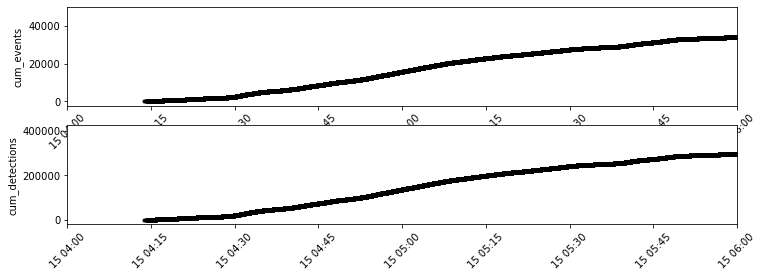

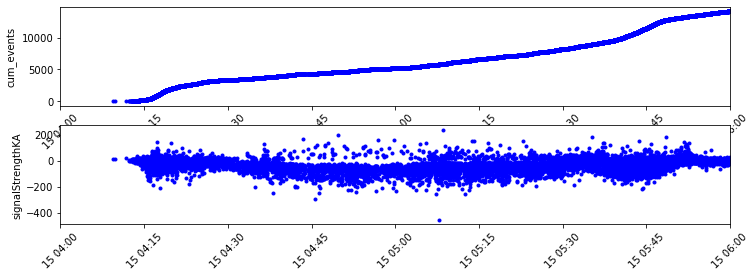

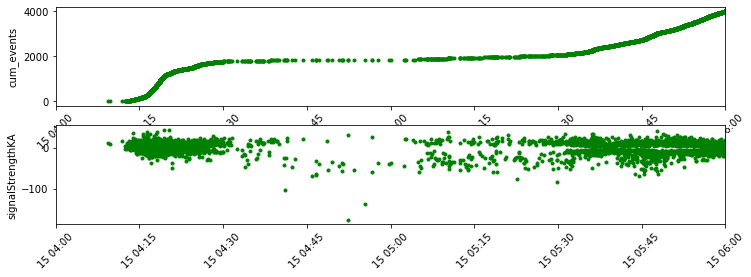

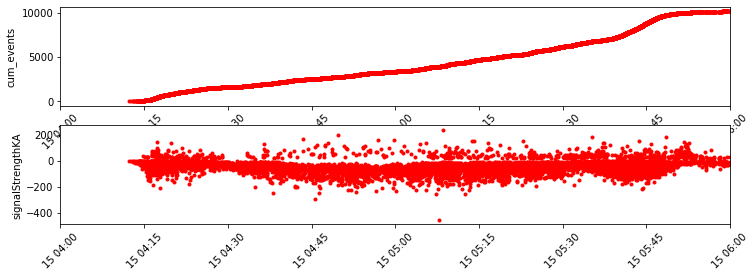

In [64]:
stime = datetime(2022, 1, 15, 4, 0, 0)
#etime = '2022-01-15 16:00:00'
etime = datetime(2022, 1, 15, 6, 0, 0)
maxDistance = 10000.0

plot_wwlln(wwllndf, starttime=stime, endtime=etime, radiusM=maxDistance )
plot_gld360(gld360df, starttime=stime, endtime=etime, radiusM=maxDistance)
plot_gld360(gld360df, lightning_type='cloud2cloud', starttime=stime, endtime=etime, radiusM=maxDistance)
plot_gld360(gld360df, lightning_type='cloud2ground', starttime=stime, endtime=etime, radiusM=maxDistance)

In [65]:
def filter_df(df, starttime, endtime, radiusM=12500000 ):
    df2 = df.copy()
    
    # time filter
    df3 = df2.loc[(df2['datetime'] >= stime) & (df2['datetime'] < etime)]
    
    # spatial filter
    df4 = df3.loc[ (df3['distanceM'] < radiusM)] 
    
    return df4

# filter
#stime = '2022-01-15 03:00:00'
#etime = '2022-01-15 17:00:00'
wwlln_filt = filter_df(wwllndf, starttime=stime, endtime=stime, radiusM=maxDistance)
gld360_filt = filter_df(gld360df, starttime=stime, endtime=stime, radiusM=maxDistance)

#wwllnf.head(500)

In [66]:
# Next we want to bin the data in 0.01 s intervals.
def bin_by_seconds(dfin, dt=60):    
    df2 = dfin.set_index('datetime', inplace=False)
    counts = df2.resample('%ds' % dt).sum()
    #print(counts)
    return counts

seconds = 10
binned_wwlln = bin_by_seconds(wwlln_filt, seconds)
binned_gld360 = bin_by_seconds(gld360_filt, seconds)

Text(0, 0.5, 'Flashes per 10s')

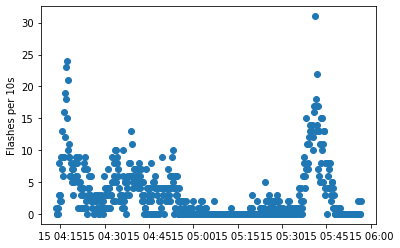

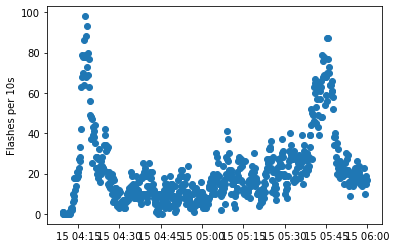

In [67]:
fig, ax = plt.subplots(1,1)
ax.plot_date(binned_wwlln.index, binned_wwlln.ones)
ax.set_ylabel('Flashes per %ds' % seconds)

fig, ax = plt.subplots(1,1)
ax.plot_date(binned_gld360.index, binned_gld360.ones)
ax.set_ylabel('Flashes per %ds' % seconds)

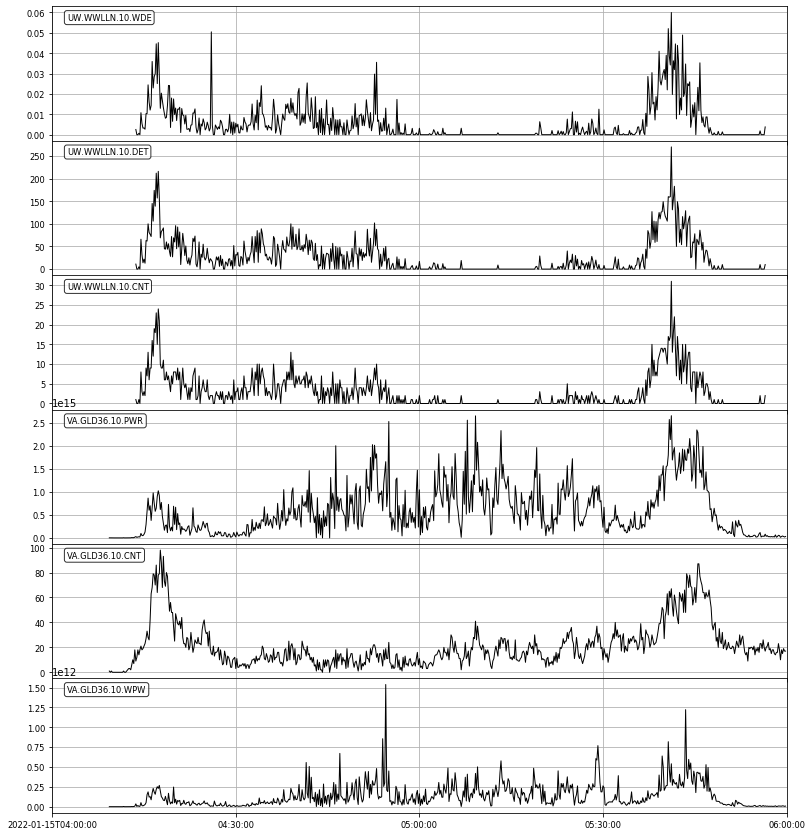

In [68]:
def column2Trace(df, colname, seconds, net='', sta='', chan=''):
    tr = obspy.Trace()
    tr.id = '%s.%s.%d.%s' % (net, sta, seconds, chan)
    tr.stats.starttime = obspy.UTCDateTime(df.index[0])
    tr.stats.delta = seconds
    tr.data = np.array(df[colname])
    return tr

st = obspy.Stream()
st.append(column2Trace(binned_wwlln, 'ones', seconds, net='UW', sta='WWLLN', chan='CNT'))
st.append(column2Trace(binned_wwlln, 'num_stations', seconds, net='UW', sta='WWLLN', chan='DET'))
st.append(column2Trace(binned_wwlln, 'weightedDetections', seconds, net='UW', sta='WWLLN', chan='WDE'))
st.append(column2Trace(binned_gld360, 'ones', seconds, net='VA', sta='GLD36', chan='CNT'))
st.append(column2Trace(binned_gld360, 'signalPower', seconds, net='VA', sta='GLD36', chan='PWR'))
st.append(column2Trace(binned_gld360, 'weightedPower', seconds, net='VA', sta='GLD36', chan='WPW'))

#stime = obspy.UTCDateTime('2022-01-15 04:00:00')
#etime = obspy.UTCDateTime('2022-01-15 05:00:00')
fig  = plt.figure(figsize=(12,12))

st.plot(equal_scale=False, starttime=obspy.UTCDateTime(stime), endtime=obspy.UTCDateTime(etime), fig=fig);  
ax = fig.axes

for this_ax in ax:
    this_ax.grid()

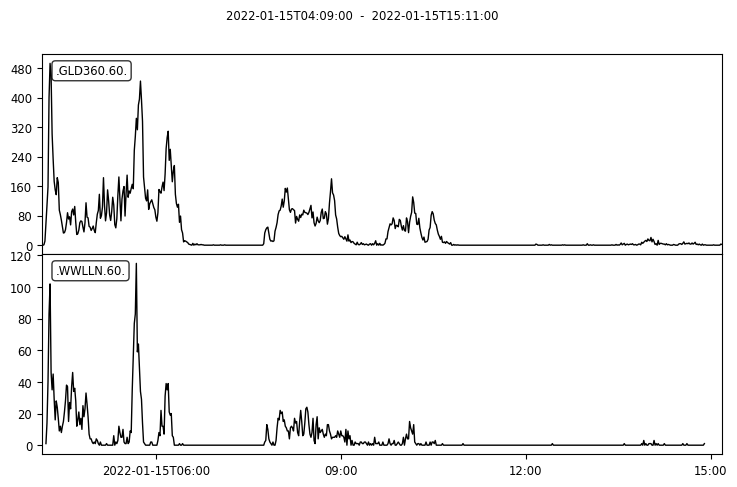

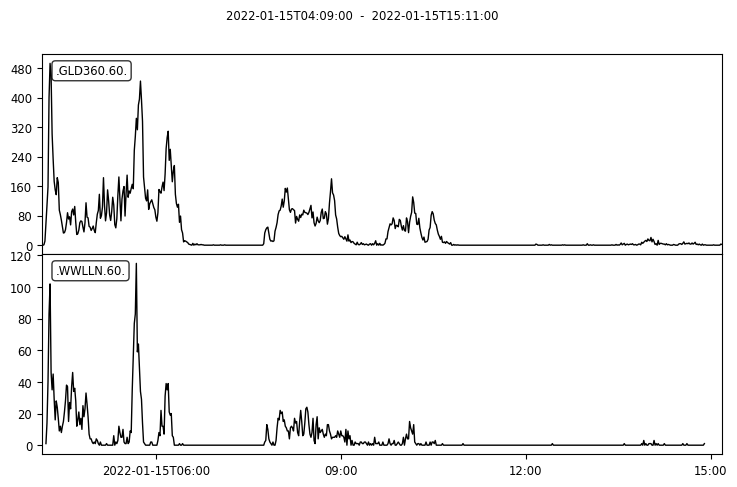

In [42]:
tr = obspy.Trace()
tr.id = '.GLD360.%d.' % seconds
tr.stats.starttime = obspy.UTCDateTime(binned_gld360.index[0])
tr.stats.delta = seconds
tr.data = np.array(binned_gld360.ones)
st.append(tr)

#stime = obspy.UTCDateTime(2022,1,15,3,30,0)
#etime = stime + 3600
st.plot(equal_scale=False);
#st.plot(equal_scale=False, starttime=stime+1150, endtime=etime-250);

#st.write('lightning_main_event.mseed')

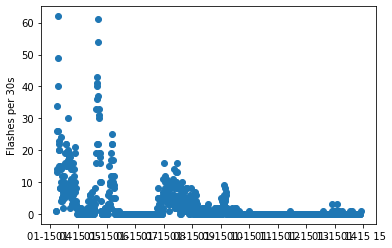

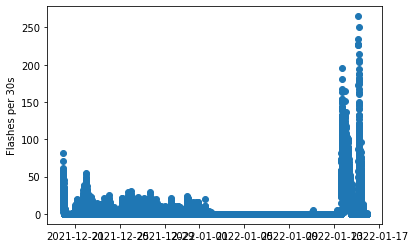

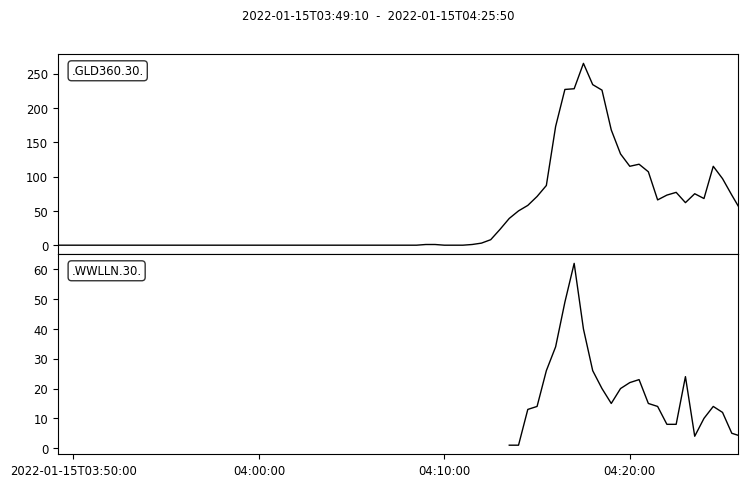

KeyError: <class 'numpy.int64'>

In [29]:
import obspy
st = obspy.Stream()
radiusM = 10000
dt = 30

df2 = wwllnf.loc[ (wwllnf['distanceM'] < radiusM)] 
wwllnf2=df2.set_index('datetime')
wwlln_hist = wwllnf2.resample('%ds' % dt).count()
fig, ax = plt.subplots(1,1)
ax.plot_date(wwlln_hist.index, wwlln_hist.ones)
ax.set_ylabel('Flashes per %ds' % dt)

df3 = gld360df.loc[ (gld360df['distanceM'] < radiusM)] 
gld360_2=df3.set_index('datetime')
gld360_hist = gld360_2.resample('%ds' % dt).count()
fig, ax = plt.subplots(1,1)
ax.plot_date(gld360_hist.index, gld360_hist.ones)
ax.set_ylabel('Flashes per %ds' % dt)

tr = obspy.Trace()
tr.id = '.WWLLN.%d.' % dt
tr.stats.starttime = obspy.UTCDateTime(wwlln_hist.index[0])
tr.stats.delta = dt
tr.data = np.array(wwlln_hist.ones)
#tr.plot()
st.append(tr)


tr = obspy.Trace()
tr.id = '.GLD360.%d.' % dt
tr.stats.starttime = obspy.UTCDateTime(gld360_hist.index[0])
tr.stats.delta = dt
tr.data = np.array(gld360_hist.ones)
#tr.plot()
st.append(tr)

stime = obspy.UTCDateTime(2022,1,15,3,30,0)
etime = stime + 3600
st.plot(equal_scale=False, starttime=stime+1150, endtime=etime-250);

st.write('lightning_main_event.mseed')

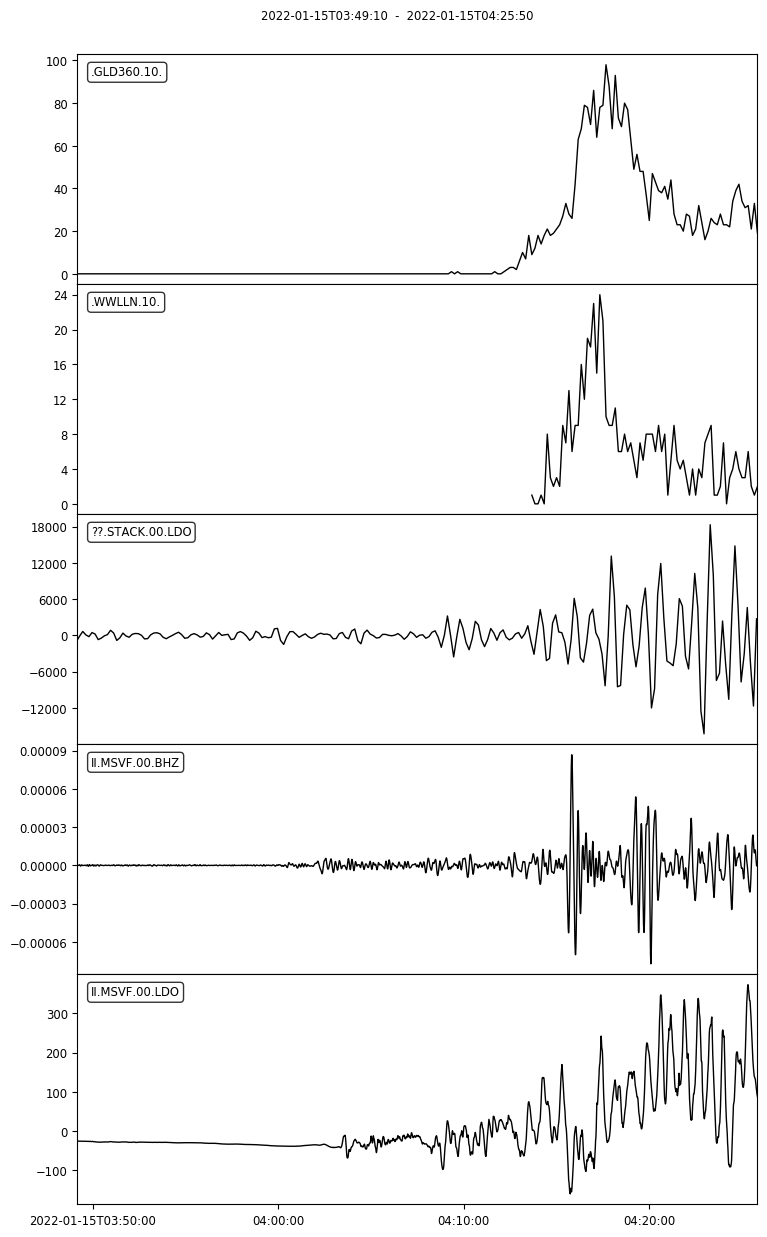

In [235]:
seismoacoustic = obspy.read('seismoacoustic_main_event.mseed')
for tr in seismoacoustic:
    st.append(tr)
st.plot(equal_scale=False, starttime=stime+1150, endtime=etime-250);

In [206]:
gld360f = gld360df.loc[(gld360df['datetime'] >= '2022-01-15 04:00:00') & (gld360df['datetime'] < '2022-01-15 05:00:00')]
gld360f.head(200)

,time,longitude,latitude,signalStrengthKA,cloud,distanceM,datetime,ones,weightedCurrent
329433,2022-01-15T04:09:24.700Z,-175.4219,-20.6038,11.7,True,8608,2022-01-15 04:09:24.700,1.0,0.001359
329434,2022-01-15T04:09:49.213Z,-175.3933,-20.5441,10.0,True,1482,2022-01-15 04:09:49.213,1.0,0.006748
329435,2022-01-15T04:11:48.590Z,-175.3893,-20.5446,17.4,True,1222,2022-01-15 04:11:48.590,1.0,0.014239
329436,2022-01-15T04:12:19.789Z,-175.3980,-20.5477,3.9,True,2114,2022-01-15 04:12:19.789,1.0,0.001845
329437,2022-01-15T04:12:20.002Z,-175.3969,-20.5658,-4.0,False,3659,2022-01-15 04:12:20.002,1.0,-0.001093
...,...,...,...,...,...,...,...,...,...
329628,2022-01-15T04:14:48.190Z,-175.4133,-20.5287,5.3,True,3359,2022-01-15 04:14:48.190,1.0,0.001578
329629,2022-01-15T04:14:49.468Z,-175.4448,-20.5646,37.2,False,7271,2022-01-15 04:14:49.468,1.0,0.005116
329630,2022-01-15T04:14:49.503Z,-175.4140,-20.5549,-4.8,False,3939,2022-01-15 04:14:49.503,1.0,-0.001219
329631,2022-01-15T04:14:50.844Z,-175.4020,-20.5324,-19.7,False,2121,2022-01-15 04:14:50.844,1.0,-0.009288


In [207]:
gld360f.tail(200)

,time,longitude,latitude,signalStrengthKA,cloud,distanceM,datetime,ones,weightedCurrent
452780,2022-01-15T04:59:57.716Z,-175.7072,-19.5395,-77.4,False,115896,2022-01-15 04:59:57.716,1.0,-0.000668
452781,2022-01-15T04:59:57.717Z,-176.0447,-21.2129,-89.4,False,102009,2022-01-15 04:59:57.717,1.0,-0.000876
452782,2022-01-15T04:59:57.723Z,-175.7297,-21.0223,-54.9,False,65044,2022-01-15 04:59:57.723,1.0,-0.000844
452783,2022-01-15T04:59:57.735Z,-174.4009,-21.3134,-81.8,False,133625,2022-01-15 04:59:57.735,1.0,-0.000612
452784,2022-01-15T04:59:57.738Z,-176.0204,-20.2218,-82.8,False,75158,2022-01-15 04:59:57.738,1.0,-0.001102
...,...,...,...,...,...,...,...,...,...
452975,2022-01-15T04:59:59.941Z,-176.1171,-19.9373,-44.9,False,101557,2022-01-15 04:59:59.941,1.0,-0.000442
452976,2022-01-15T04:59:59.945Z,-175.0969,-20.9903,95.1,False,58571,2022-01-15 04:59:59.945,1.0,0.001624
452977,2022-01-15T04:59:59.961Z,-175.8696,-20.5404,123.6,False,50775,2022-01-15 04:59:59.961,1.0,0.002434
452978,2022-01-15T04:59:59.975Z,-174.7749,-20.7582,137.3,False,67830,2022-01-15 04:59:59.975,1.0,0.002024
